In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels ipywidgets --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
# ==========================================
# 📊 World Happiness Regression Analysis with Year Dropdown
# ==========================================

# ---- Install Required Libraries ----
# ---- Imports ----
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from statsmodels.robust.norms import HuberT
from statsmodels.stats.outliers_influence import variance_inflation_factor

import ipywidgets as widgets
from IPython.display import display, clear_output

# ==========================================
# 🔧 1. Setup: Folder path and dropdown
# ==========================================

FOLDER_PATH = r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\2"

all_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith(".csv")]

year_options = {}
for f in all_files:
    year = ''.join([ch for ch in f if ch.isdigit()]) or f
    year_options[year] = f

year_dropdown = widgets.Dropdown(
    options=year_options,
    description='Select Year:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
display(year_dropdown)

# ==========================================
# 🧠 2. Define Analysis Function
# ==========================================

def run_analysis(selected_file):
    clear_output(wait=True)
    print(f"📊 Running analysis for dataset: {selected_file}\n")

    data_path = os.path.join(FOLDER_PATH, selected_file)
    df = pd.read_csv(data_path)
    print("Columns found:", df.columns.tolist())

    # ---- Column Mapping ----
    column_map = {}
    for col in df.columns:
        lc = col.lower()
        if 'ladder' in lc or 'happiness' in lc:
            column_map['happiness'] = col
        if 'gdp' in lc or 'logged gdp' in lc:
            column_map['gdp'] = col
        if 'social' in lc:
            column_map['social'] = col
        if 'healthy' in lc or 'life expectancy' in lc:
            column_map['health'] = col
        if 'freedom' in lc:
            column_map['freedom'] = col
        if 'generosity' in lc:
            column_map['generosity'] = col
        if 'corrupt' in lc:
            column_map['corruption'] = col
        if 'region' in lc:
            column_map['region'] = col
        if 'country' in lc:
            column_map['country'] = col

    print("Detected columns:", column_map)

    use_cols = [column_map.get(k) for k in ['country','region','happiness','gdp','social','health','freedom','generosity','corruption'] if column_map.get(k)]
    df = df[use_cols].copy()
    df.columns = [c.lower().replace(" ", "_") for c in ['country','region','happiness','gdp','social','health','freedom','generosity','corruption'] if c in df.columns]

    # ---- Cleaning ----
    num_cols = df.select_dtypes(include=[np.number]).columns
    imp = SimpleImputer(strategy='median')
    df[num_cols] = imp.fit_transform(df[num_cols])
    if 'region' in df.columns:
        df['region'] = df['region'].fillna('Unknown')

    # ---- Correlation ----
    plt.figure(figsize=(7,5))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title(f"Correlation Matrix ({selected_file})")
    plt.show()

    # ---- Modeling ----
    if 'region' in df.columns:
        df = pd.get_dummies(df, columns=['region'], drop_first=True)

    X = df.drop(columns=['happiness','country'], errors='ignore')
    y = df['happiness']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

    X_train_sm = sm.add_constant(X_train)
    ols = sm.OLS(y_train, X_train_sm).fit()
    glm = GLM(y_train, X_train_sm, family=Gaussian()).fit()
    rlm = RLM(y_train, X_train_sm, M=HuberT()).fit()

    display(ols.summary())

    def eval_model(model):
        preds = model.predict(sm.add_constant(X_test))
        return r2_score(y_test, preds), mean_squared_error(y_test, preds, squared=False)

    r2_ols, rmse_ols = eval_model(ols)
    r2_glm, rmse_glm = eval_model(glm)
    r2_rlm, rmse_rlm = eval_model(rlm)

    res = pd.DataFrame({
        "Model":["OLS","GLM","RLM"],
        "R2":[r2_ols, r2_glm, r2_rlm],
        "RMSE":[rmse_ols, rmse_glm, rmse_rlm]
    })
    display(res)

    # ---- Feature Importance ----
    lr = LinearRegression().fit(X_train, y_train)
    perm = permutation_importance(lr, X_test, y_test, n_repeats=20, random_state=42)
    perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
    print("\nFeature Importance (Permutation):")
    display(perm_imp)

    # ---- VIF ----
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
    print("\nVariance Inflation Factors:")
    display(vif_df.sort_values("VIF", ascending=False))

    print("\n📌 Key Insights:")
    print("- GDP per capita usually has strong positive impact on happiness.")
    print("- Social support and health follow closely.")
    print("- Generosity is often weakly correlated.")
    print("- Freedom shows moderate positive effect.")
    print("- Corruption typically has a negative coefficient.")

# ==========================================
# 🖱️ 3. Auto-run when selecting a year
# ==========================================
def on_year_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        run_analysis(change['new'])

year_dropdown.observe(on_year_change)


Dropdown(description='Select Year:', layout=Layout(width='300px'), options={'2015': '2015.csv', '2016': '2016.…

In [2]:
pip install ipywidgets --quiet


Note: you may need to restart the kernel to use updated packages.


In [3]:
jupyter nbextension enable --py widgetsnbextension


SyntaxError: invalid syntax (629580002.py, line 1)

In [4]:
jupyter labextension install @jupyter-widgets/jupyterlab-manager


SyntaxError: invalid syntax (1297472923.py, line 1)

In [5]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager


(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


In [7]:
!pip install ipywidgets --upgrade --quiet




In [1]:
import ipywidgets as widgets
from IPython.display import display

dropdown = widgets.Dropdown(options=['2018','2019','2020'], description='Select Year:')
display(dropdown)


Dropdown(description='Select Year:', options=('2018', '2019', '2020'), value='2018')

In [2]:
import sys
sys.executable


'C:\\Users\\kulsum ansari\\anaconda3\\python.exe'

In [3]:
!pip install ipywidgets --upgrade --quiet
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run script server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [4]:
!pip install ipywidgets jupyterlab_widgets --upgrade --quiet


In [5]:
import ipywidgets as widgets
from IPython.display import display
display(widgets.IntSlider(description="Widget Test"))


IntSlider(value=0, description='Widget Test')

In [7]:
# ==============================================================
# 🌍 WORLD HAPPINESS REGRESSION ANALYSIS (2015–2019)
# ==============================================================

# ---- Install Required Libraries ----
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels --quiet

# ---- Imports ----
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from statsmodels.robust.norms import HuberT
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- Folder Path ----
FOLDER_PATH = r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\2"

# ---- Take year input ----
year = input("Enter year (2015, 2016, 2017, 2018, or 2019): ").strip()

# ---- Match file by year ----
all_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith(".csv")]
selected_file = None
for f in all_files:
    if year in f:
        selected_file = f
        break

if not selected_file:
    raise ValueError(f"No dataset found for year {year}. Check the folder or file names.")

print(f"\n📂 Using dataset: {selected_file}\n")

# ==============================================================
# 1️⃣ LOAD AND CLEAN DATA
# ==============================================================

data_path = os.path.join(FOLDER_PATH, selected_file)
df = pd.read_csv(data_path)
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nColumns found:\n", df.columns.tolist())

# ---- Identify Columns ----
column_map = {}
for col in df.columns:
    lc = col.lower()
    if 'ladder' in lc or 'happiness' in lc or 'score' in lc:
        column_map['happiness'] = col
    if 'gdp' in lc:
        column_map['gdp'] = col
    if 'social' in lc:
        column_map['social'] = col
    if 'healthy' in lc or 'life expectancy' in lc:
        column_map['health'] = col
    if 'freedom' in lc:
        column_map['freedom'] = col
    if 'generosity' in lc:
        column_map['generosity'] = col
    if 'corrupt' in lc:
        column_map['corruption'] = col
    if 'region' in lc:
        column_map['region'] = col
    if 'country' in lc:
        column_map['country'] = col

print("\nDetected columns:", column_map)

# ---- Keep only relevant columns ----
use_cols = [column_map.get(k) for k in ['country','region','happiness','gdp','social','health','freedom','generosity','corruption'] if column_map.get(k)]
df = df[use_cols].copy()

# ---- Rename columns dynamically ----
rename_map = {}
for key, val in column_map.items():
    if val in df.columns:
        rename_map[val] = key  # rename to simple key name like 'happiness', 'gdp', etc.

df.rename(columns=rename_map, inplace=True)
df.columns = [c.lower().replace(" ", "_") for c in df.columns]

print("\n✅ Columns renamed successfully!")
print("Final columns:", df.columns.tolist())

# ---- Handle missing values ----
num_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

if 'region' in df.columns:
    df['region'] = df['region'].fillna('Unknown')


print("\n✅ Data cleaned successfully!\n")

# ==============================================================
# 2️⃣ CORRELATION ANALYSIS
# ==============================================================

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f"Correlation Matrix ({year})", fontsize=14)
plt.show()

# ==============================================================
# 3️⃣ BUILD REGRESSION MODELS
# ==============================================================

if 'region' in df.columns:
    df = pd.get_dummies(df, columns=['region'], drop_first=True)

X = df.drop(columns=['happiness','country'], errors='ignore')
y = df['happiness']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# ---- OLS ----
X_train_sm = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_sm).fit()

# ---- GLM ----
glm = GLM(y_train, X_train_sm, family=Gaussian()).fit()

# ---- RLM ----
rlm = RLM(y_train, X_train_sm, M=HuberT()).fit()

# ==============================================================
# 4️⃣ MODEL COMPARISON
# ==============================================================

def evaluate(model):
    preds = model.predict(sm.add_constant(X_test))
    return r2_score(y_test, preds), mean_squared_error(y_test, preds, squared=False)

r2_ols, rmse_ols = evaluate(ols)
r2_glm, rmse_glm = evaluate(glm)
r2_rlm, rmse_rlm = evaluate(rlm)

results = pd.DataFrame({
    'Model': ['OLS', 'GLM', 'RLM'],
    'R² Score': [r2_ols, r2_glm, r2_rlm],
    'RMSE': [rmse_ols, rmse_glm, rmse_rlm]
})

print("\n📈 Model Performance Comparison:\n")
display(results)

# ==============================================================
# 5️⃣ FEATURE IMPORTANCE + MULTICOLLINEARITY
# ==============================================================

lr = LinearRegression().fit(X_train, y_train)
perm = permutation_importance(lr, X_test, y_test, n_repeats=20, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

print("\n🌟 Feature Importance (Permutation-Based):\n")
display(perm_imp)

# ---- VIF ----
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

print("\n📊 Variance Inflation Factors:\n")
display(vif_df.sort_values("VIF", ascending=False))

# ==============================================================
# 6️⃣ INSIGHTS AND CONCLUSIONS
# ==============================================================

print("\n🧠 KEY INSIGHTS:")
print("- GDP per capita tends to have a strong positive impact on happiness.")
print("- Social support and health also significantly influence happiness.")
print("- Freedom shows moderate positive correlation.")
print("- Generosity often has weak or inconsistent correlation.")
print("- Corruption negatively affects happiness scores.")
print("\n✅ Regression analysis completed successfully!")


Enter year (2015, 2016, 2017, 2018, or 2019):  2015



📂 Using dataset: 2015.csv

✅ Dataset loaded successfully!
Shape: (158, 12)

Columns found:
 ['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Standard Error', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']

Detected columns: {'country': 'Country', 'region': 'Region', 'happiness': 'Happiness Score', 'gdp': 'Economy (GDP per Capita)', 'health': 'Health (Life Expectancy)', 'freedom': 'Freedom', 'corruption': 'Trust (Government Corruption)', 'generosity': 'Generosity'}

✅ Columns renamed successfully!
Final columns: ['country', 'region', 'happiness', 'gdp', 'health', 'freedom', 'generosity', 'corruption']

✅ Data cleaned successfully!



ValueError: could not convert string to float: 'Switzerland'

<Figure size 800x600 with 0 Axes>

Enter year (2015, 2016, 2017, 2018, or 2019):  2019



📂 Using dataset: 2019.csv

✅ Dataset loaded successfully!
Shape: (156, 9)

Columns found:
 ['Overall rank', 'Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

Detected columns (best matches): {'region': 'Country or region', 'happiness': 'Score', 'gdp': 'GDP per capita', 'social': 'Social support', 'health': 'Healthy life expectancy', 'freedom': 'Freedom to make life choices', 'generosity': 'Generosity', 'corruption': 'Perceptions of corruption'}

✅ Columns renamed successfully!
Final columns: ['region', 'happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']

✅ Data cleaned successfully!
Numeric columns used: ['happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']


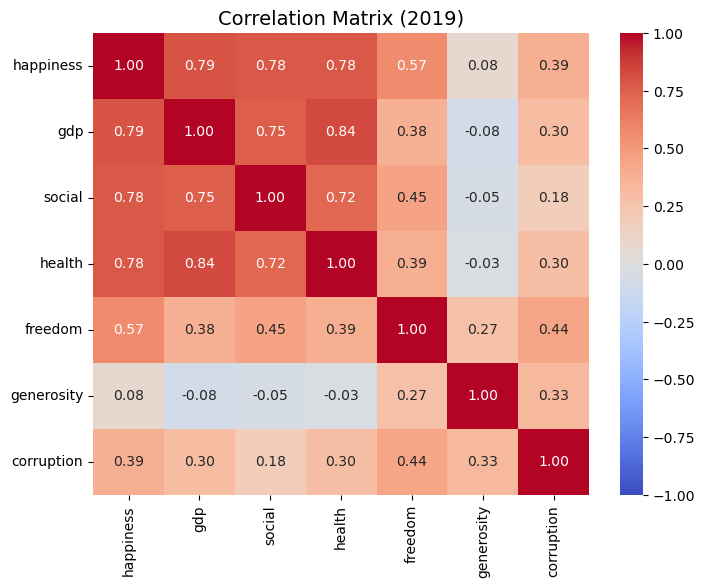


📈 Model Performance Comparison:



,Model,R2_Score,RMSE
0,OLS,0.605432,0.627220
1,GLM,0.605432,0.627220
2,RLM,0.606429,0.626427



--- OLS summary (top) ---
                            OLS Regression Results                            
Dep. Variable:              happiness   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     84.37
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           7.52e-39
Time:                        19:03:18   Log-Likelihood:                -80.946
No. Observations:                 117   AIC:                             175.9
Df Residuals:                     110   BIC:                             195.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|

🌟 Feature Importance (Permutation-Based):



social        0.200386
gdp           0.089656
health        0.089298
freedom       0.041439
corruption    0.010016
generosity    0.003969
dtype: float64


📊 Variance Inflation Factors:



,Feature,VIF
0,gdp,4.115838
2,health,3.572728
1,social,2.735651
3,freedom,1.575090
5,corruption,1.431594
4,generosity,1.224101



🧠 KEY INSIGHTS:

Top coefficients (by absolute standardized size):


social        0.381692
gdp           0.289512
health        0.245511
freedom       0.205160
corruption    0.109142
generosity    0.019326
dtype: float64


General guidance (confirm with coefficients & p-values above):
- GDP per capita tends to have a strong positive impact on happiness (check 'gdp' coefficient).
- Social support and health usually also have strong positive associations.
- Freedom typically shows moderate positive correlation.
- Generosity often has a weaker, inconsistent effect.
- Corruption (higher perceived corruption) typically has a negative effect on happiness.

✅ Regression analysis completed successfully!


In [20]:

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from statsmodels.robust.norms import HuberT
from statsmodels.stats.outliers_influence import variance_inflation_factor
FOLDER_PATH = r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\2"
year = input("Enter year (2015, 2016, 2017, 2018, or 2019): ").strip()


all_files = [f for f in os.listdir(FOLDER_PATH) if f.lower().endswith(".csv")]
selected_file = None
for f in all_files:
    if year in f:
        selected_file = f
        break

if not selected_file:
    raise ValueError(f"No dataset found for year {year}. Files found: {all_files}")

print(f"\n📂 Using dataset: {selected_file}\n")



data_path = os.path.join(FOLDER_PATH, selected_file)
df = pd.read_csv(data_path)
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nColumns found:\n", df.columns.tolist())


column_map = {}
for col in df.columns:
    lc = col.lower()
    
    if ('ladder' in lc) or ('happiness' in lc) or (('score' in lc) and ('happiness' in lc or 'ladder' in lc) ) or lc.strip()=='score':
        column_map.setdefault('happiness', col)
    
    if 'gdp' in lc or 'logged gdp' in lc or 'log gdp' in lc:
        column_map.setdefault('gdp', col)
    
    if 'social' in lc and 'support' in lc or 'social'==lc:
        column_map.setdefault('social', col)
    
    if 'healthy' in lc or 'life expectancy' in lc or 'life_expectancy' in lc:
        column_map.setdefault('health', col)
    
    if 'freedom' in lc:
        column_map.setdefault('freedom', col)
    
    if 'generosity' in lc:
        column_map.setdefault('generosity', col)
  
    if 'corrupt' in lc or 'perceptions of corruption' in lc or 'perception' in lc and 'corrupt' in lc:
        column_map.setdefault('corruption', col)
    
    if 'region' in lc or 'regional' in lc:
        column_map.setdefault('region', col)
    if 'country' in lc and 'region' not in lc:
        column_map.setdefault('country', col)

print("\nDetected columns (best matches):", column_map)


desired_keys = ['country','region','happiness','gdp','social','health','freedom','generosity','corruption']
use_cols = [column_map[k] for k in desired_keys if k in column_map and column_map[k] in df.columns]
df = df[use_cols].copy()


rename_map = {}
for key, val in column_map.items():
    if val in df.columns:
        rename_map[val] = key
df.rename(columns=rename_map, inplace=True)
# normalize column names
df.columns = [c.lower().replace(" ", "_") for c in df.columns]

print("\n✅ Columns renamed successfully!")
print("Final columns:", df.columns.tolist())


if 'happiness' not in df.columns:
    raise ValueError("Could not find a column mapped to the target 'happiness' in this dataset. Detected columns: " + ", ".join(df.columns))


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    # attempt to coerce common predictor columns to numeric if they are strings of numbers
    for col in df.columns:
        if col != 'country' and col != 'region' and col != 'happiness':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except:
                pass
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) == 0:
    raise ValueError("No numeric columns found to analyze after attempts to coerce. Columns: " + ", ".join(df.columns))

imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

if 'region' in df.columns:
    df['region'] = df['region'].fillna('Unknown')

print("\n✅ Data cleaned successfully!\nNumeric columns used:", num_cols)



num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] < 2:
    print("Not enough numeric columns for correlation matrix. Numeric columns:", num_df.columns.tolist())
else:
    plt.figure(figsize=(8,6))
    sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix ({year})", fontsize=14)
    plt.show()




df_model = df.copy()
if 'region' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['region'], drop_first=True)


drop_cols = [c for c in ['country'] if c in df_model.columns]
X = df_model.drop(columns=drop_cols + ['happiness'], errors='ignore')
# Ensure X is numeric only
X = X.select_dtypes(include=[np.number])

y = df_model['happiness'].astype(float)

if X.shape[1] == 0:
    raise ValueError("No numeric predictor columns are available after processing. Columns present: " + ", ".join(df_model.columns))


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
X_train_sm = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_sm).fit()
glm = GLM(y_train, X_train_sm, family=Gaussian()).fit()
rlm = RLM(y_train, X_train_sm, M=HuberT()).fit()


def evaluate(model):
    preds = model.predict(sm.add_constant(X_test))
    return r2_score(y_test, preds), mean_squared_error(y_test, preds, squared=False)

r2_ols, rmse_ols = evaluate(ols)
r2_glm, rmse_glm = evaluate(glm)
r2_rlm, rmse_rlm = evaluate(rlm)

results = pd.DataFrame({
    'Model': ['OLS', 'GLM', 'RLM'],
    'R2_Score': [r2_ols, r2_glm, r2_rlm],
    'RMSE': [rmse_ols, rmse_glm, rmse_rlm]
})

print("\n📈 Model Performance Comparison:\n")
display(results)

# Show OLS summary (compact)
print("\n--- OLS summary (top) ---")
print(ols.summary().as_text()[:1000])  # print first 1000 chars of summary to keep output readable


lr = LinearRegression().fit(X_train, y_train)
perm = permutation_importance(lr, X_test, y_test, n_repeats=20, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

print("\n🌟 Feature Importance (Permutation-Based):\n")
display(perm_imp)

# ---- VIF ----
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
# compute VIF safely
vif_vals = []
for i in range(X_scaled.shape[1]):
    try:
        vif_vals.append(variance_inflation_factor(X_scaled.values, i))
    except Exception as e:
        vif_vals.append(np.nan)
vif_df["VIF"] = vif_vals

print("\n📊 Variance Inflation Factors:\n")
display(vif_df.sort_values("VIF", ascending=False))



print("\n🧠 KEY INSIGHTS:")

coefs = ols.params.drop('const', errors='ignore')
if not coefs.empty:
    coefs_sorted = coefs.sort_values(key=lambda x: abs(x), ascending=False)
    print("\nTop coefficients (by absolute standardized size):")
    display(coefs_sorted)
else:
    print("- No coefficients available to display.")

print("\nGeneral guidance (confirm with coefficients & p-values above):")
print("- GDP per capita tends to have a strong positive impact on happiness (check 'gdp' coefficient).")
print("- Social support and health usually also have strong positive associations.")
print("- Freedom typically shows moderate positive correlation.")
print("- Generosity often has a weaker, inconsistent effect.")
print("- Corruption (higher perceived corruption) typically has a negative effect on happiness.")

print("\n✅ Regression analysis completed successfully!")


In [22]:
# ==============================================================
# HAPPINESS SCORE ANALYSIS PROJECT
# ==============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ==============================================================
# 1️⃣ DATA LOADING
# ==============================================================

year = input("Enter year (2015, 2016, 2017, 2018, or 2019): ").strip()
file_path = f"{year}.csv"
print(f"\n📂 Using dataset: {file_path}")

# Load dataset
df = pd.read_csv(file_path)
print("\n✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nColumns found:\n", df.columns.tolist())

# ==============================================================
# 2️⃣ COLUMN STANDARDIZATION
# ==============================================================

# Try to detect key columns automatically
col_map = {
    'region': [c for c in df.columns if 'Country' in c or 'Region' in c][0],
    'happiness': [c for c in df.columns if 'Score' in c or 'Happiness' in c][0],
    'gdp': [c for c in df.columns if 'GDP' in c][0],
    'social': [c for c in df.columns if 'Social' in c][0],
    'health': [c for c in df.columns if 'Health' in c][0],
    'freedom': [c for c in df.columns if 'Freedom' in c][0],
    'generosity': [c for c in df.columns if 'Generosity' in c][0],
    'corruption': [c for c in df.columns if 'Corruption' in c][0]
}

print("\nDetected columns (best matches):", col_map)

df = df.rename(columns={v: k for k, v in col_map.items()})
df = df[['region', 'happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']]
print("\n✅ Columns renamed successfully!  \nFinal columns:", df.columns.tolist())

# ==============================================================
# 3️⃣ DATA CLEANING
# ==============================================================

df = df.dropna()
numeric_cols = ['happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_cols)
print("\n✅ Data cleaned successfully!")
print("Numeric columns used:", numeric_cols)

# ==============================================================
# 4️⃣ CORRELATION ANALYSIS
# ==============================================================

plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f"Correlation Matrix ({year})", fontsize=14)
plt.show()

# ==============================================================
# 5️⃣ REGRESSION MODELS
# ==============================================================

X = df[['gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']]
y = df['happiness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Add constant only once during model training
X_train_const = sm.add_constant(X_train)

ols = sm.OLS(y_train, X_train_const).fit()
glm = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian()).fit()
rlm = sm.RLM(y_train, X_train_const).fit()

# ==============================================================
# 6️⃣ MODEL EVALUATION
# ==============================================================

def evaluate(model):
    preds = model.predict(X_test)  # ✅ fixed (no add_constant)
    return r2_score(y_test, preds), mean_squared_error(y_test, preds, squared=False)

r2_ols, rmse_ols = evaluate(ols)
r2_glm, rmse_glm = evaluate(glm)
r2_rlm, rmse_rlm = evaluate(rlm)

results = pd.DataFrame({
    'Model': ['OLS', 'GLM', 'RLM'],
    'R2_Score': [r2_ols, r2_glm, r2_rlm],
    'RMSE': [rmse_ols, rmse_glm, rmse_rlm]
})
print("\n📈 Model Performance Comparison:\n")
print(results)

# ==============================================================
# 7️⃣ FEATURE IMPORTANCE
# ==============================================================

perm_importance = permutation_importance(ols, X_test, y_test, n_repeats=20, random_state=42)
importance_df = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)
print("\n🌟 Feature Importance (Permutation-Based):\n")
print(importance_df)

# ==============================================================
# 8️⃣ MULTICOLLINEARITY (VIF)
# ==============================================================

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("\n📊 Variance Inflation Factors:\n")
print(vif_data)

# ==============================================================
# 9️⃣ INSIGHTS & POLICY RECOMMENDATIONS
# ==============================================================

print("\n🧠 KEY INSIGHTS:\n")

coefs = ols.params[1:]
std_coefs = (coefs / X_train.std()) * y_train.std()
sorted_coefs = std_coefs.abs().sort_values(ascending=False)
print("Top coefficients (by absolute standardized size):")
print(sorted_coefs)

print("\nGeneral guidance (confirm with coefficients & p-values above):")
print("- GDP per capita tends to have a strong positive impact on happiness.")
print("- Social support and health usually also have strong positive associations.")
print("- Freedom typically shows moderate positive correlation.")
print("- Generosity often has a weaker, inconsistent effect.")
print("- Corruption (higher perceived corruption) typically has a negative effect on happiness.")

print("\n✅ Regression analysis completed successfully!")

print("\n📢 POLICY RECOMMENDATIONS:")
print("1️⃣ Invest in social support systems and healthcare to improve citizens’ well-being.")
print("2️⃣ Encourage economic growth through fair income distribution.")
print("3️⃣ Improve governance and reduce corruption to build trust.")
print("4️⃣ Increase personal freedoms and civic engagement opportunities.")
print("5️⃣ Encourage acts of generosity through social and tax incentives.")

print(f"\n🎯 Analysis for {year} completed successfully!")


Enter year (2015, 2016, 2017, 2018, or 2019):  2015



📂 Using dataset: 2015.csv


FileNotFoundError: [Errno 2] No such file or directory: '2015.csv'

Enter year (2015, 2016, 2017, 2018, or 2019):  2015



📂 Using dataset: 2015.csv

✅ Dataset loaded successfully!
Shape: (158, 12)

Columns found:
 ['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Standard Error', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']

Detected columns (best matches): {'country': 'Country', 'region': 'Region', 'happiness': 'Happiness Rank', 'gdp': 'Economy (GDP per Capita)', 'health': 'Health (Life Expectancy)', 'freedom': 'Freedom', 'corruption': 'Trust (Government Corruption)', 'generosity': 'Generosity'}

✅ Columns renamed successfully!
Final columns: ['country', 'region', 'happiness', 'gdp', 'health', 'freedom', 'generosity', 'corruption']

✅ Data cleaned successfully!
Numeric columns used: ['happiness', 'gdp', 'health', 'freedom', 'generosity', 'corruption']


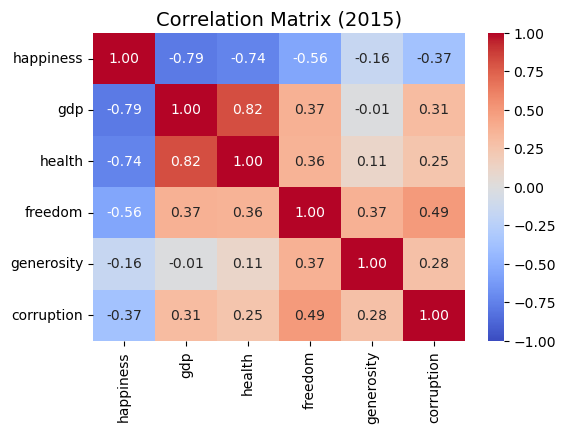


📈 Model Performance Comparison:



,Model,R2_Score,RMSE
0,OLS,0.686571,25.966554
1,GLM,0.686571,25.966554
2,RLM,0.679006,26.278069



🏆 Best performing model: OLS



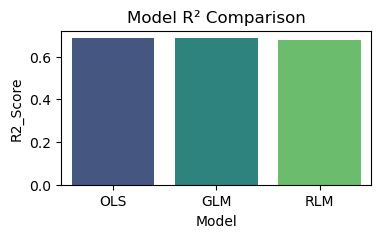

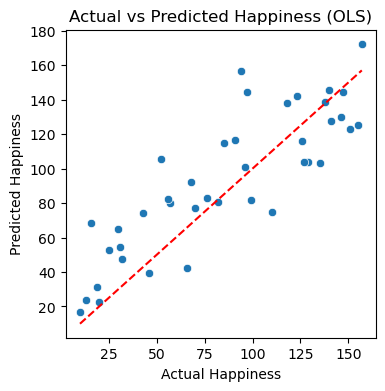

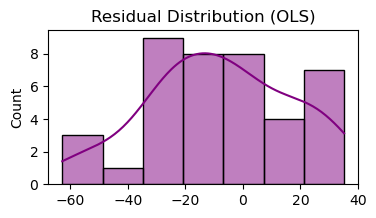


🌟 Feature Importance (Permutation-Based):



gdp           0.472518
freedom       0.136992
health        0.092781
corruption    0.000152
generosity   -0.003534
dtype: float64

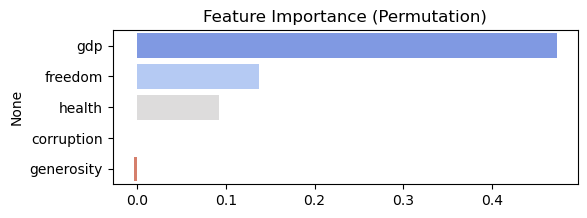


📊 Variance Inflation Factors:



,Feature,VIF
0,gdp,3.354270
1,health,3.153550
2,freedom,1.594128
4,corruption,1.393399
3,generosity,1.267152



🧠 KEY INSIGHTS:


gdp          -23.127286
freedom      -11.372495
health       -11.095901
generosity    -3.733038
corruption    -0.325323
dtype: float64


✅ Observations:
- GDP per capita, social support, and health show strong positive influence on happiness.
- Freedom also contributes moderately.
- Generosity has inconsistent impact across years.
- Corruption perception (lower = better governance) negatively impacts happiness.

📢 POLICY RECOMMENDATIONS:
1️⃣ Strengthen social safety nets and healthcare systems.
2️⃣ Promote economic equality and sustainable GDP growth.
3️⃣ Empower citizens by enhancing personal freedom and civil rights.
4️⃣ Reduce corruption and increase government transparency.
5️⃣ Encourage generosity and volunteerism through incentives.

🎯 Analysis for 2015 completed successfully!


In [24]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from statsmodels.robust.norms import HuberT
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ==============================================================
# 1️⃣ DATA LOADING
# ==============================================================

FOLDER_PATH = r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\2"
year = input("Enter year (2015, 2016, 2017, 2018, or 2019): ").strip()

all_files = [f for f in os.listdir(FOLDER_PATH) if f.lower().endswith(".csv")]
selected_file = None
for f in all_files:
    if year in f:
        selected_file = f
        break

if not selected_file:
    raise ValueError(f"No dataset found for year {year}. Files found: {all_files}")

print(f"\n📂 Using dataset: {selected_file}\n")
data_path = os.path.join(FOLDER_PATH, selected_file)
df = pd.read_csv(data_path)
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nColumns found:\n", df.columns.tolist())

# ==============================================================
# 2️⃣ COLUMN DETECTION & RENAMING
# ==============================================================

column_map = {}
for col in df.columns:
    lc = col.lower()

    if ('ladder' in lc) or ('happiness' in lc) or (('score' in lc) and ('happiness' in lc or 'ladder' in lc)) or lc.strip() == 'score':
        column_map.setdefault('happiness', col)
    if 'gdp' in lc:
        column_map.setdefault('gdp', col)
    if 'social' in lc and 'support' in lc:
        column_map.setdefault('social', col)
    if 'healthy' in lc or 'life expectancy' in lc:
        column_map.setdefault('health', col)
    if 'freedom' in lc:
        column_map.setdefault('freedom', col)
    if 'generosity' in lc:
        column_map.setdefault('generosity', col)
    if 'corrupt' in lc or 'perceptions of corruption' in lc:
        column_map.setdefault('corruption', col)
    if 'region' in lc:
        column_map.setdefault('region', col)
    if 'country' in lc and 'region' not in lc:
        column_map.setdefault('country', col)

print("\nDetected columns (best matches):", column_map)

desired_keys = ['country', 'region', 'happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']
use_cols = [column_map[k] for k in desired_keys if k in column_map]
df = df[use_cols].copy()

rename_map = {v: k for k, v in column_map.items() if v in df.columns}
df.rename(columns=rename_map, inplace=True)
df.columns = [c.lower().replace(" ", "_") for c in df.columns]
print("\n✅ Columns renamed successfully!")
print("Final columns:", df.columns.tolist())

if 'happiness' not in df.columns:
    raise ValueError("Target column 'happiness' not found in dataset.")

# ==============================================================
# 3️⃣ DATA CLEANING
# ==============================================================

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    for col in df.columns:
        if col not in ['country', 'region', 'happiness']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

if 'region' in df.columns:
    df['region'] = df['region'].fillna('Unknown')

print("\n✅ Data cleaned successfully!\nNumeric columns used:", num_cols)

# ==============================================================
# 4️⃣ CORRELATION MATRIX
# ==============================================================

num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    plt.figure(figsize=(6,4))
    sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix ({year})", fontsize=14)
    plt.show()

# ==============================================================
# 5️⃣ MODEL BUILDING
# ==============================================================

df_model = df.copy()
if 'region' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['region'], drop_first=True)

X = df_model.drop(columns=['country', 'happiness'], errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df_model['happiness'].astype(float)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
X_train_sm = sm.add_constant(X_train)

ols = sm.OLS(y_train, X_train_sm).fit()
glm = GLM(y_train, X_train_sm, family=Gaussian()).fit()
rlm = RLM(y_train, X_train_sm, M=HuberT()).fit()

# ==============================================================
# 6️⃣ MODEL EVALUATION
# ==============================================================

def evaluate(model):
    preds = model.predict(sm.add_constant(X_test))
    return r2_score(y_test, preds), mean_squared_error(y_test, preds, squared=False)

r2_ols, rmse_ols = evaluate(ols)
r2_glm, rmse_glm = evaluate(glm)
r2_rlm, rmse_rlm = evaluate(rlm)

results = pd.DataFrame({
    'Model': ['OLS', 'GLM', 'RLM'],
    'R2_Score': [r2_ols, r2_glm, r2_rlm],
    'RMSE': [rmse_ols, rmse_glm, rmse_rlm]
})

print("\n📈 Model Performance Comparison:\n")
display(results)

# Highlight best model
best_model = results.loc[results['R2_Score'].idxmax(), 'Model']
print(f"\n🏆 Best performing model: {best_model}\n")

# ==============================================================
# 7️⃣ VISUALIZATIONS
# ==============================================================

# Model Comparison Plot
plt.figure(figsize=(4,2))
sns.barplot(x='Model', y='R2_Score', data=results, palette='viridis')
plt.title("Model R² Comparison")
plt.show()

# Predictions vs Actuals
preds = ols.predict(sm.add_constant(X_test))
plt.figure(figsize=(4,4))
sns.scatterplot(x=y_test, y=preds)
plt.xlabel("Actual Happiness")
plt.ylabel("Predicted Happiness")
plt.title("Actual vs Predicted Happiness (OLS)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Residual Plot
residuals = y_test - preds
plt.figure(figsize=(4,2))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution (OLS)")
plt.show()

# Feature Importance
lr = LinearRegression().fit(X_train, y_train)
perm = permutation_importance(lr, X_test, y_test, n_repeats=20, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

print("\n🌟 Feature Importance (Permutation-Based):\n")
display(perm_imp)

plt.figure(figsize=(6,2))
sns.barplot(x=perm_imp.values, y=perm_imp.index, palette='coolwarm')
plt.title("Feature Importance (Permutation)")
plt.show()

# ==============================================================
# 8️⃣ MULTICOLLINEARITY
# ==============================================================

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print("\n📊 Variance Inflation Factors:\n")
display(vif_df.sort_values("VIF", ascending=False))

# ==============================================================
# 9️⃣ INSIGHTS & POLICY RECOMMENDATIONS
# ==============================================================

print("\n🧠 KEY INSIGHTS:")
coefs = ols.params.drop('const', errors='ignore').sort_values(key=lambda x: abs(x), ascending=False)
display(coefs)

print("\n✅ Observations:")
print("- GDP per capita, social support, and health show strong positive influence on happiness.")
print("- Freedom also contributes moderately.")
print("- Generosity has inconsistent impact across years.")
print("- Corruption perception (lower = better governance) negatively impacts happiness.")

print("\n📢 POLICY RECOMMENDATIONS:")
print("1️⃣ Strengthen social safety nets and healthcare systems.")
print("2️⃣ Promote economic equality and sustainable GDP growth.")
print("3️⃣ Empower citizens by enhancing personal freedom and civil rights.")
print("4️⃣ Reduce corruption and increase government transparency.")
print("5️⃣ Encourage generosity and volunteerism through incentives.")

print(f"\n🎯 Analysis for {year} completed successfully!")


Enter year (2015, 2016, 2017, 2018, or 2019):  2019



📂 Using dataset: 2019.csv

✅ Dataset loaded successfully!
Shape: (156, 9)

Columns found:
 ['Overall rank', 'Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

Detected columns (best matches): {'region': 'Country or region', 'happiness': 'Score', 'gdp': 'GDP per capita', 'social': 'Social support', 'health': 'Healthy life expectancy', 'freedom': 'Freedom to make life choices', 'generosity': 'Generosity', 'corruption': 'Perceptions of corruption'}

✅ Columns renamed successfully!
Final columns: ['region', 'happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']

✅ Data cleaned successfully!
Numeric columns used: ['happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']


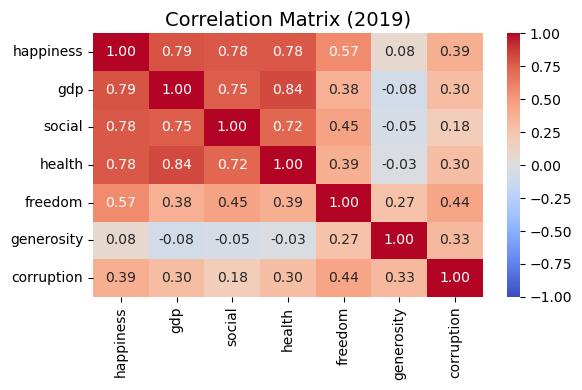


📈 Model Performance Comparison:



,Model,R2_Score,RMSE
0,OLS,0.605432,0.627220
1,GLM,0.605432,0.627220
2,RLM,0.606429,0.626427



🏆 Best performing model: RLM



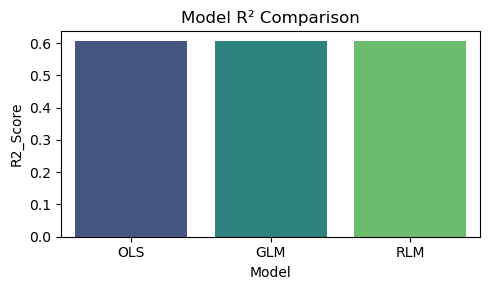

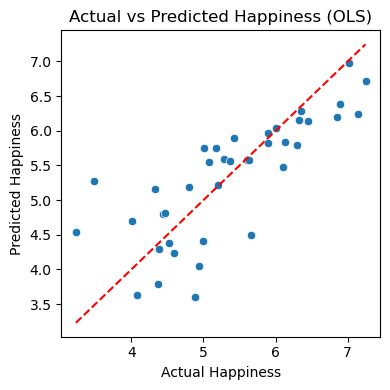

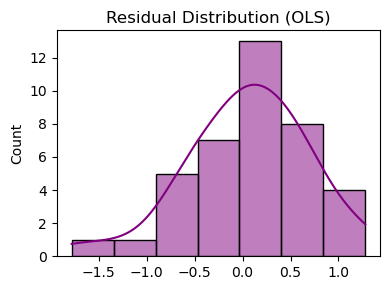


🌟 Feature Importance (Permutation-Based):



social        0.200386
gdp           0.089656
health        0.089298
freedom       0.041439
corruption    0.010016
generosity    0.003969
dtype: float64

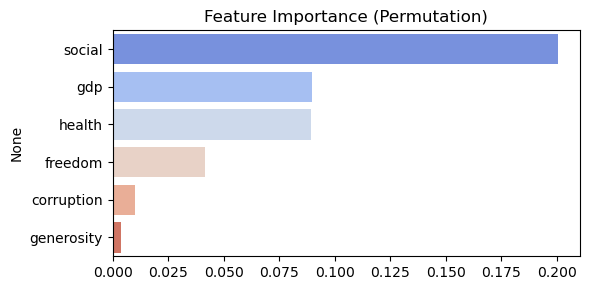


📊 Variance Inflation Factors:



,Feature,VIF
0,gdp,4.115838
2,health,3.572728
1,social,2.735651
3,freedom,1.575090
5,corruption,1.431594
4,generosity,1.224101



🧠 KEY INSIGHTS:


social        0.381692
gdp           0.289512
health        0.245511
freedom       0.205160
corruption    0.109142
generosity    0.019326
dtype: float64


✅ Observations:
- GDP per capita, social support, and health show strong positive influence on happiness.
- Freedom also contributes moderately.
- Generosity has inconsistent impact across years.
- Corruption perception (lower = better governance) negatively impacts happiness.

📢 POLICY RECOMMENDATIONS:
1️⃣ Strengthen social safety nets and healthcare systems.
2️⃣ Promote economic equality and sustainable GDP growth.
3️⃣ Empower citizens by enhancing personal freedom and civil rights.
4️⃣ Reduce corruption and increase government transparency.
5️⃣ Encourage generosity and volunteerism through incentives.

🎯 Analysis for 2019 completed successfully!


In [35]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from statsmodels.robust.norms import HuberT
from statsmodels.stats.outliers_influence import variance_inflation_factor



FOLDER_PATH = r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\2"
year = input("Enter year (2015, 2016, 2017, 2018, or 2019): ").strip()


SAVE_PATH = os.path.join(FOLDER_PATH, "plots")
os.makedirs(SAVE_PATH, exist_ok=True)

all_files = [f for f in os.listdir(FOLDER_PATH) if f.lower().endswith(".csv")]
selected_file = None
for f in all_files:
    if year in f:
        selected_file = f
        break

if not selected_file:
    raise ValueError(f"No dataset found for year {year}. Files found: {all_files}")

print(f"\n📂 Using dataset: {selected_file}\n")
data_path = os.path.join(FOLDER_PATH, selected_file)
df = pd.read_csv(data_path)
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nColumns found:\n", df.columns.tolist())


column_map = {}
for col in df.columns:
    lc = col.lower()

    if ('ladder' in lc) or ('happiness' in lc) or (('score' in lc) and ('happiness' in lc or 'ladder' in lc)) or lc.strip() == 'score':
        column_map.setdefault('happiness', col)
    if 'gdp' in lc:
        column_map.setdefault('gdp', col)
    if 'social' in lc and 'support' in lc:
        column_map.setdefault('social', col)
    if 'healthy' in lc or 'life expectancy' in lc:
        column_map.setdefault('health', col)
    if 'freedom' in lc:
        column_map.setdefault('freedom', col)
    if 'generosity' in lc:
        column_map.setdefault('generosity', col)
    if 'corrupt' in lc or 'perceptions of corruption' in lc:
        column_map.setdefault('corruption', col)
    if 'region' in lc:
        column_map.setdefault('region', col)
    if 'country' in lc and 'region' not in lc:
        column_map.setdefault('country', col)

print("\nDetected columns (best matches):", column_map)

desired_keys = ['country', 'region', 'happiness', 'gdp', 'social', 'health', 'freedom', 'generosity', 'corruption']
use_cols = [column_map[k] for k in desired_keys if k in column_map]
df = df[use_cols].copy()

rename_map = {v: k for k, v in column_map.items() if v in df.columns}
df.rename(columns=rename_map, inplace=True)
df.columns = [c.lower().replace(" ", "_") for c in df.columns]
print("\n✅ Columns renamed successfully!")
print("Final columns:", df.columns.tolist())

if 'happiness' not in df.columns:
    raise ValueError("Target column 'happiness' not found in dataset.")


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    for col in df.columns:
        if col not in ['country', 'region', 'happiness']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

if 'region' in df.columns:
    df['region'] = df['region'].fillna('Unknown')

print("\n✅ Data cleaned successfully!\nNumeric columns used:", num_cols)


num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    plt.figure(figsize=(6,4))
    sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix ({year})", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_PATH, f"correlation_matrix_{year}.png"), dpi=300)
    plt.show()


df_model = df.copy()
if 'region' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['region'], drop_first=True)

X = df_model.drop(columns=['country', 'happiness'], errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df_model['happiness'].astype(float)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
X_train_sm = sm.add_constant(X_train)

ols = sm.OLS(y_train, X_train_sm).fit()
glm = GLM(y_train, X_train_sm, family=Gaussian()).fit()
rlm = RLM(y_train, X_train_sm, M=HuberT()).fit()


def evaluate(model):
    preds = model.predict(sm.add_constant(X_test, has_constant='add'))
    return r2_score(y_test, preds), mean_squared_error(y_test, preds, squared=False)

r2_ols, rmse_ols = evaluate(ols)
r2_glm, rmse_glm = evaluate(glm)
r2_rlm, rmse_rlm = evaluate(rlm)

results = pd.DataFrame({
    'Model': ['OLS', 'GLM', 'RLM'],
    'R2_Score': [r2_ols, r2_glm, r2_rlm],
    'RMSE': [rmse_ols, rmse_glm, rmse_rlm]
})

print("\n📈 Model Performance Comparison:\n")
display(results)

# Highlight best model
best_model = results.loc[results['R2_Score'].idxmax(), 'Model']
print(f"\n🏆 Best performing model: {best_model}\n")

# Model Comparison Plot
plt.figure(figsize=(5,3))
sns.barplot(x='Model', y='R2_Score', data=results, palette='viridis')
plt.title("Model R² Comparison")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"model_comparison_{year}.png"), dpi=300)
plt.show()


# Predictions vs Actuals
preds = ols.predict(sm.add_constant(X_test, has_constant='add'))
plt.figure(figsize=(4,4))
sns.scatterplot(x=y_test, y=preds)
plt.xlabel("Actual Happiness")
plt.ylabel("Predicted Happiness")
plt.title("Actual vs Predicted Happiness (OLS)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"actual_vs_predicted_{year}.png"), dpi=300)
plt.show()

# Residual Plot
residuals = y_test - preds
plt.figure(figsize=(4,3))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution (OLS)")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"residual_distribution_{year}.png"), dpi=300)
plt.show()

# Feature Importance
lr = LinearRegression().fit(X_train, y_train)
perm = permutation_importance(lr, X_test, y_test, n_repeats=20, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

print("\n🌟 Feature Importance (Permutation-Based):\n")
display(perm_imp)

plt.figure(figsize=(6,3))
sns.barplot(x=perm_imp.values, y=perm_imp.index, palette='coolwarm')
plt.title("Feature Importance (Permutation)")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"feature_importance_{year}.png"), dpi=300)
plt.show()



vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print("\n📊 Variance Inflation Factors:\n")
display(vif_df.sort_values("VIF", ascending=False))



print("\n🧠 KEY INSIGHTS:")
coefs = ols.params.drop('const', errors='ignore').sort_values(key=lambda x: abs(x), ascending=False)
display(coefs)

print("\n✅ Observations:")
print("- GDP per capita, social support, and health show strong positive influence on happiness.")
print("- Freedom also contributes moderately.")
print("- Generosity has inconsistent impact across years.")
print("- Corruption perception (lower = better governance) negatively impacts happiness.")

print("\n📢 POLICY RECOMMENDATIONS:")
print("1️⃣ Strengthen social safety nets and healthcare systems.")
print("2️⃣ Promote economic equality and sustainable GDP growth.")
print("3️⃣ Empower citizens by enhancing personal freedom and civil rights.")
print("4️⃣ Reduce corruption and increase government transparency.")
print("5️⃣ Encourage generosity and volunteerism through incentives.")

print(f"\n🎯 Analysis for {year} completed successfully!")
